# Прогнозирование вероятности оттока пользователей для фитнес-центров
## Описание проекта
Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Отдел по работе с клинетами перевел данные клиентов в электронный вид. Задача — провести анализ и подготовить план действий по удержанию клиентов. 

## Задачи
1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.
    
## Итоги
В данном проекте использовано машинное обучение. Спрогнозирована вероятность оттока (на уровне следующего месяца) для каждого клиента; сформированы типичные портреты пользователей: выделены наиболее яркие группы, охарактеризованы их основные свойства; проанализированы основные признаки, наиболее сильно влияющие на отток.
    
## Содержание проекта
1. [Изучение общей информации и подготовка данных](#header_1)
2. [Исследовательский анализ](#header_2)
3. [Построение модели прогнозирования оттока клиентов](#header_3)
4. [Кластеризация клиентов](#header_4)
5. [Выводы](#header_5)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings
warnings.filterwarnings('ignore')

sns.set(context = 'notebook', 
        font_scale = 1, 
        style="whitegrid", 
        palette='YlGnBu_r')

In [3]:
PATH = ('datasets/gym_churn.csv')

# Изучение общей информации и подготовка данных <a id = 'header_1'></a>

## Формулирование бизнес-задачи
**Что мы прогнозируем и какую бизнес-задачу этим решаем?**

1. Прогнозируем вероятность оттока в следующем месяце по данным текущего месяца. 
2. Сегментируем клиентов.

---

**Какие данные для этого есть?**  

Данные о факте оттока на 1 число текущего месяца. 
Также есть общая информация о клиенте по состоянию на прошый месяц и данные о посещении зала за предыдущий месяц. 

---
  
**Кто и как будет использовать модель (как она встраивается в бизнес-процесс)?** 

Результаты моделирования будет использовать отдел по работе с клиентами. Модель позволит определить клиентов, для которых есть риск оттока. Менеджеры смогут вовремя предотвратить таких клиентов, провести работу по повтороному вовлечению. Например если будет выявлена зависимость между посещением групповых занятий и оттоком, то можно будет скорректировать условия проведения занятий. Если же групповые занятия наоборот способствуют удержанию, то можно предлагать их клиентам, которые потенциально могут попасть в отток.

<img src = "https://www.altexsoft.com/media/2019/03/https-lh3-googleusercontent-com-purwbwzko1ru9ji2.png" width = 80%>

---

**Какие результаты хотим получить?**
- **_какой бизнес-эффект может дать ваша модель?_** Увеличение срока жизни клиента => увеличение оборота/прибыли 
- **_по каким метрикам будем оценивать качество работы модели?_** LTV, Оборот, Прибыль

## Формализация задачи и её перевод на язык машинного обучения  
### Отток
**Тип задачи** 

Обучение с учителем, задача классификации. Целевая переменная — "факт оттока". Решаем задачу бинарной классификации со следующими классами: 
- пользователь не уйдет в отток ("0"),
- пользователь уйдет в отток ("1")

**Алгоритм**

1. Логистическая регрессия. Особенности: если выборка не сбалансированная, то нужно подбирать порог вероятности, по которому происходит деление на классы.     
2. Дерево принятия решений
3. Случайный лес

Метрики для оптимизации и оценки качества модели:
(TP — True positive, TN — True negative, FP — false positive, FN — false negative).
- Доля правильных ответов (accuracy). 

$$\frac{TP + TN}{TP + TN + FP + FN}$$

- Точность (precision). Покажет, как много пользователей модель ошибочно относит к оттоку.

$$\frac{TP}{TP + FP}$$

- Полнота (recall).  Покажет, как много пользователей модель упускает и не относит к оттоку.

$$\frac{TP}{TP + FN}$$

Из двух метрик — точность и полнота — при прогнозировании оттока для нас важнее будет метрика полноты, так как не заметить пользователя, уходящего в отток, дороже для бизнес-процессов, чем ошибочно отнести пользователя к оттоку. 


### Сегментация
**Тип задачи**

Обучение без учителя, задача кластеризации. 

**Алгоритм**

K-Means, Агломеративная иерархическая кластеризация. 

Метрики для оптимизации и оценки качества моделей: метрика силуэта.


## Подготовка данных

In [4]:
data = pd.read_csv(PATH)
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Предположительно в поле `Month_to_end_contract` хранятся целочисленные данные. Проверим и если это так, приведем `Month_to_end_contract` к типу `int`.

In [6]:
# проверка на целочисленность данных в поле Month_to_end_contract
tmp = data.loc[data['Month_to_end_contract'].notna()]['Month_to_end_contract']            
if np.array_equal(tmp, tmp.astype(int)):
    print('Данные в столбце Month_to_end_contract целочисленные')

Данные в столбце Month_to_end_contract целочисленные


In [7]:
data['Month_to_end_contract'] = data['Month_to_end_contract'].astype('int')

Приведем наименования полей к удобному виду.

In [8]:
# приведение названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [9]:
# создадим словарь соответствия: название полей — расшифровка на русском
col_names_ru = {'churn':'Отток',
                'gender':'Пол',
                'near_location': 'Проживание/работа',
                'partner':'Сотрудник партнера',
                'promo_friends':'Приведи друга',
                'phone':'Телефон',
                'age':'Возраст',
                'lifetime':'Lifetime',
                'contract_period':'Длит-ть абонемента',
                'month_to_end_contract':'Срок до конца аб.',
                'group_visits':'Групповые',
                'avg_class_frequency_total':'Посещения/нед. все время',
                'avg_class_frequency_current_month':'Посещения/нед.пред.мес',
                'avg_additional_charges_total':'Выручка доп.усл.',
                'cluster':'Кластер'
               }

# Исследовательский анализ данных <a id = 'header_2'></a>

**В датасете содержится информация:**

- `churn` — факт оттока в текущем месяце;

*Данные клиента за предыдущий до проверки факта оттока месяц*:
- `gender` — пол;
- `near_location` — проживание или работа в районе, где находится фитнес-центр;
- `partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `phone` — наличие контактного телефона;
- `age` — возраст;
- `lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

*Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента*:
- `contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `group_visits` — факт посещения групповых занятий;
- `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [10]:
# проверка на дубли
print('Количество полных дублей:', data.duplicated().sum())

Количество полных дублей: 0


In [11]:
# проверка на пропуски
print('Количество пропусков по каждому из полей:\n', data.isnull().sum())

Количество пропусков по каждому из полей:
 gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64


In [12]:
data_described = data.describe().T.reset_index().rename(columns = {'index':'feature'})
data_described

,feature,count,mean,std,min,25%,50%,75%,max
0,gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
1,near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
2,partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
3,promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
4,phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
5,contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
6,group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
7,age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
8,avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
9,month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [13]:
# рассмотрим средние значения для тех, кто ушел в отток и для тех, кто не ушел
# и сравним со средним значением по всем данным
data_grouped_mean = data.groupby('churn').mean().T.reset_index().rename(columns = {'index':'feature'})
data_grouped_mean = data_grouped_mean.merge(data_described[['feature','mean']], on = 'feature')
data_grouped_mean.rename(columns = {0:'mean_not_churn', 1:'mean_churn', 'mean':'mean_overall'})

,feature,mean_not_churn,mean_churn,mean_overall
0,gender,0.510037,0.510839,0.510250
1,near_location,0.873086,0.768143,0.845250
2,partner,0.534195,0.355325,0.486750
3,promo_friends,0.353522,0.183789,0.308500
4,phone,0.903709,0.902922,0.903500
5,contract_period,5.747193,1.728558,4.681250
6,group_visits,0.464103,0.268615,0.412250
7,age,29.976523,26.989632,29.184250
8,avg_additional_charges_total,158.445715,115.082899,146.943728
9,month_to_end_contract,5.283089,1.662582,4.322750


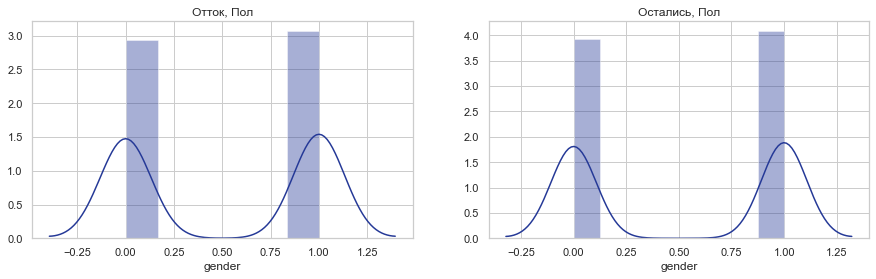

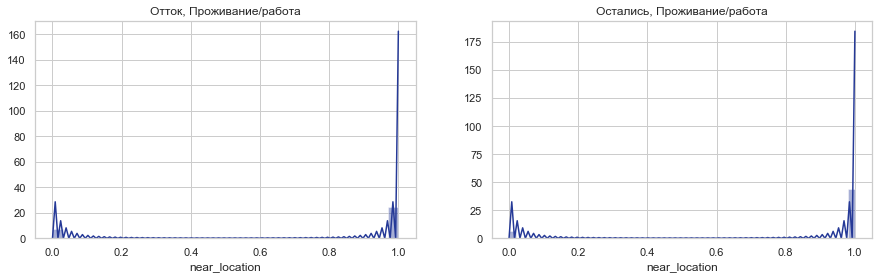

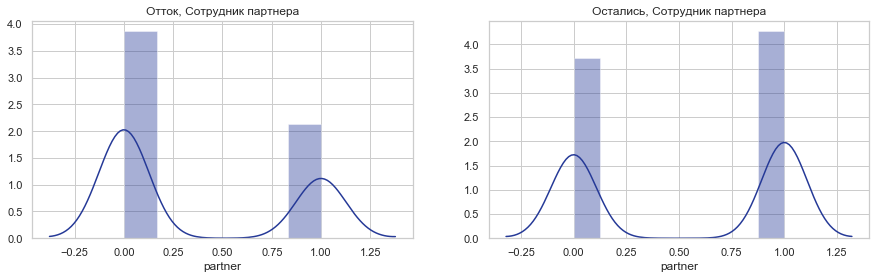

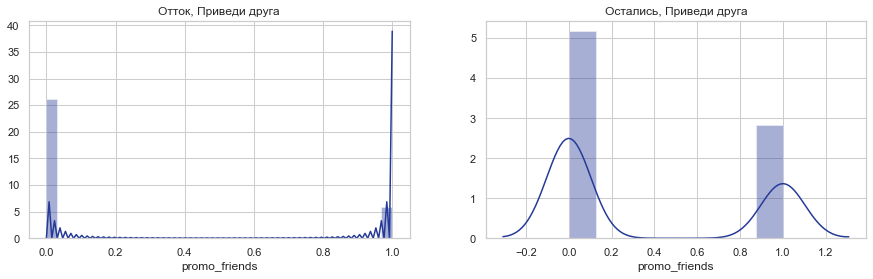

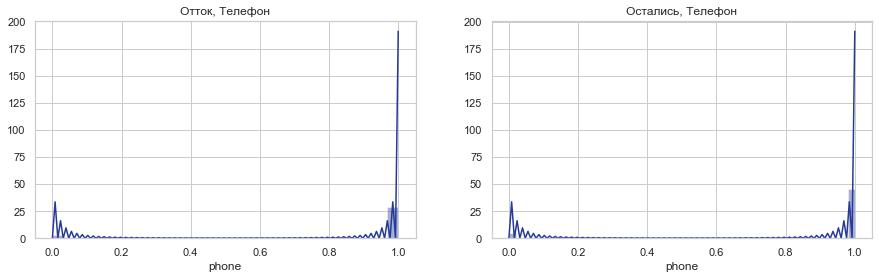

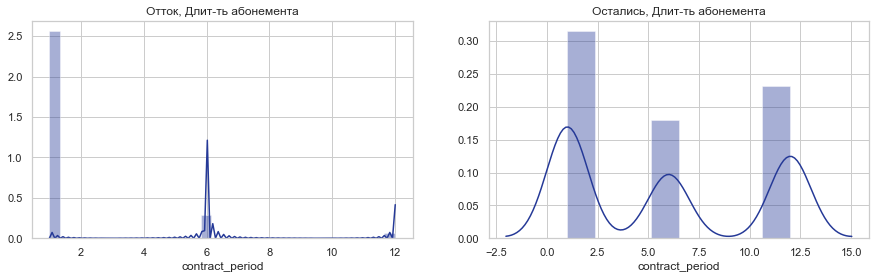

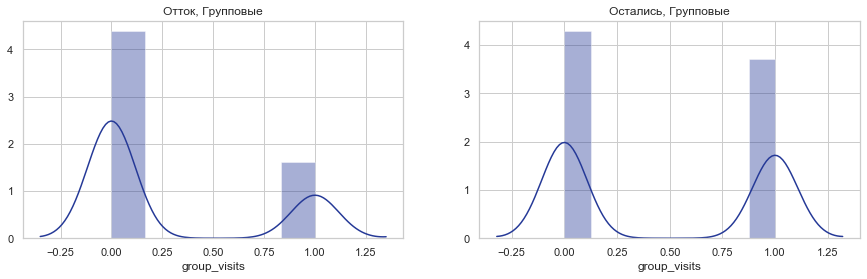

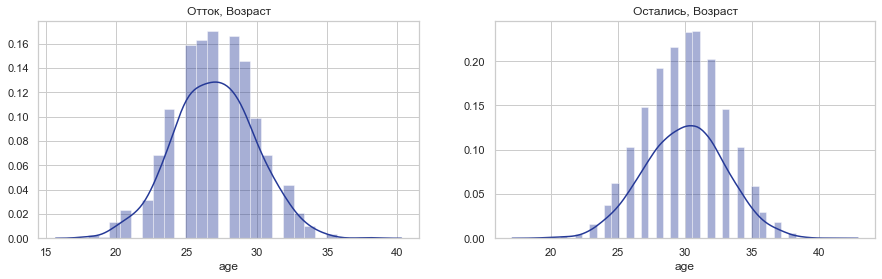

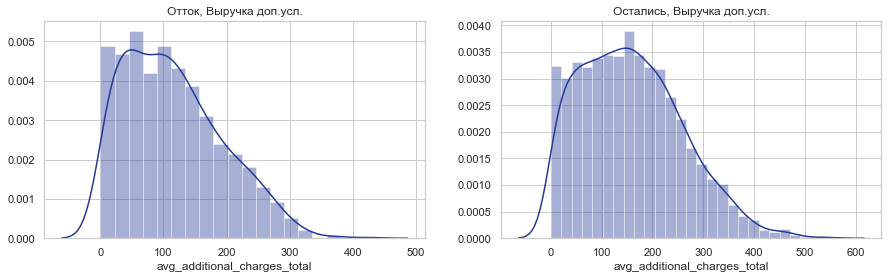

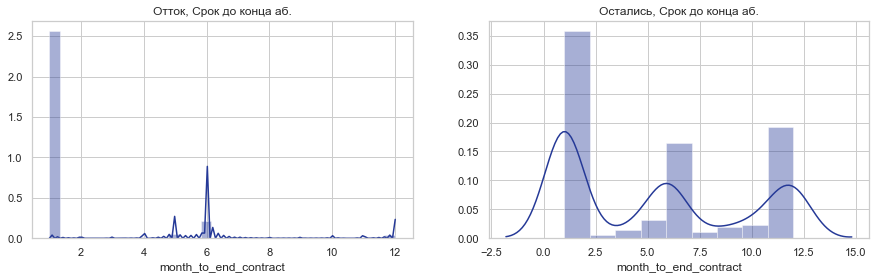

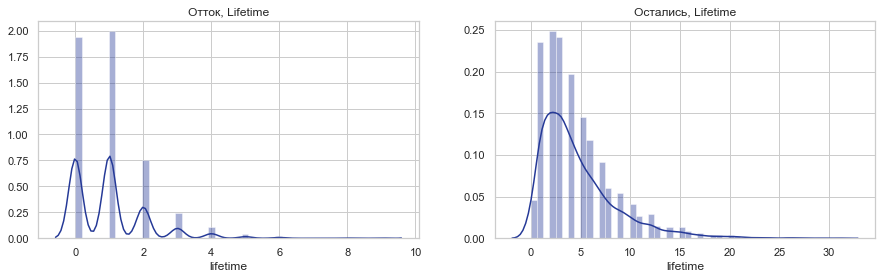

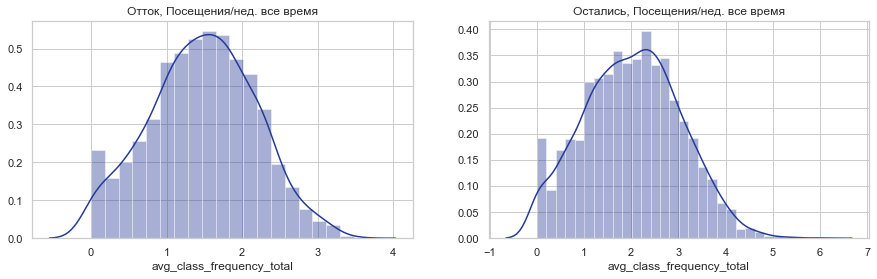

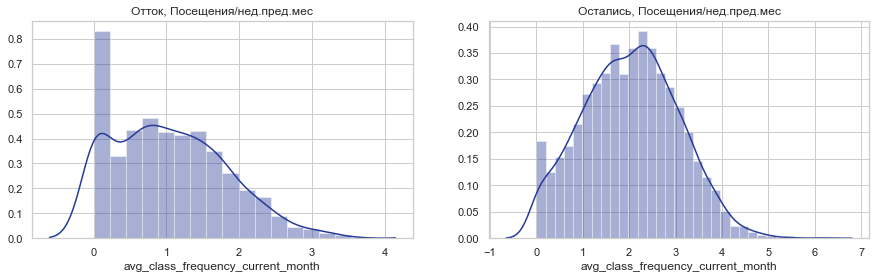

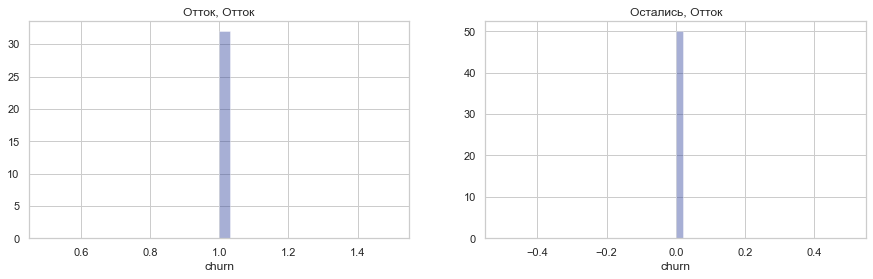

In [14]:
# поделим выборку по показателю churn
data_churn = data.query('churn == 1')
data_active = data.query('churn == 0')

# построим гистрограммы
for feature in data.columns:
    f, axes = plt.subplots(1, 2, figsize=(15, 4))
    sns.distplot(data_churn[feature], ax = axes[0])
    axes[0].set_title('Отток, ' + col_names_ru[feature])
    sns.distplot(data_active[feature], ax = axes[1])
    axes[1].set_title('Остались, ' + col_names_ru[feature])
    plt.show() 

In [14]:
# посмотрим, насколько сбалансирована выборка относительно целевой переменной
churn_grouped = data.groupby('churn', as_index = False)['gender'].count()
churn_grouped = churn_grouped.rename(columns = {'gender':'count'})
churn_grouped['%_of_all'] = churn_grouped['count']/data.shape[0]

churn_grouped

,churn,count,%_of_all
0,0,2939,0.73475
1,1,1061,0.26525


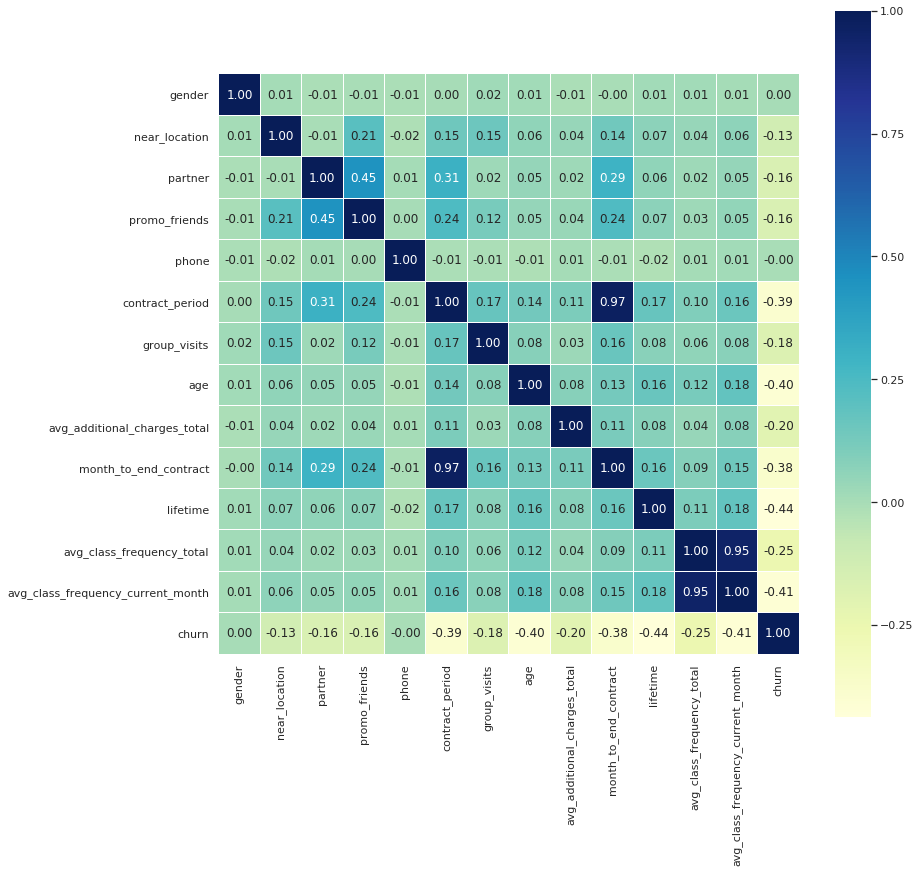

In [15]:
# построим матрицу корреляции и тепловую карту
cm = data.corr()
fig, ax = plt.subplots(figsize=(13,13)) 
sns.heatmap(cm, annot = True, square=True, ax = ax, cmap = 'YlGnBu', linewidths = 0.01, fmt=".2f")
plt.show()

## Выводы

В датасете есть категориальные и числовые признаки. Категориальные уже представлены в бинарном виде, преобразовывать их не требуется. Из-за того, что они закодированы нулями и единицами, мы не знаем, что в каждом контретном случае является нулем, а что единицей. 
Например для поля `gender` (пол) понять это невозможно. Но очевидно, что фитнесом пользуются в одинаковой степени как мужчины так и женщины.
Но для других полей — `near_location`, `partner`, `promo_friends`, `phone` — мы можем предположить: 1 это значение "да", 0 — значение "нет".  

---

Целевая переменная не имеет временной структуры. **Поэтому делить на обучающую и валидацинную выборку можно совершенно случайным образом.** 

---

В датасете нет дублей и пропущенных значений.

---

Пол и наличие номера телефона не оказывает значительного влияния; средние значения для остальных признаков выше для пользователей, не попавших в отток.
То есть показатель оттока в среднем ниже у тех, кто старше, живет ближе, пришел от партнера фитнеса или по рекомендации друга. 
Также показатель оттока ниже для пользователей, у которых более длительный контракт, были групповые занятия, отмечены более частые посещения, высокие доп.траты и более продолжительный lifetime.

---

Выборка сбалансированная относительно целевой переменной: распределение примерно 70/30 (выбрка считается несбалансированной, если распределение 90/10 и хуже). **Устанавливать кастомные трешхолд не требуется**.

---

Самая яркая корреляция с целевой переменной:
- lifetime
- средняя частота посещений в неделю за предыдущий месяц
- возраст
- длительность контракта/количество месяцев до окончания контракта

Самая незначительная корреляция: 
- пол, 
- возраст. 

Во всех случаях коэффициент корреляции отрицательный — с ростом одной из указанных переменных уменьшается показатель оттока.

---

Присутствуют сильноскоррелированные признаки:
- "длительность контракта" и "количество месяцев до окончания контракта"
- "средняя частота посещений в неделю за предыдущий месяц" и "средняя частота посещений в неделю за все время с начала действия абонемента"
- "сотрудник компании-партнёра клуба" и "факт первоначальной записи в рамках акции «приведи друга»"

Один из пары признаков можно попробовать удалить и обучить модель на уменьшенном пространстве признаков. Возможно, это улучшит результаты.

# Построение модели прогнозирования оттока клиентов <a id = 'header_3'></a>

In [16]:
# формируем вектор признаков и вектор целевой переменной
X = data.drop('churn', axis = 1)
y = data['churn']

# делим выборку на обучающую и валидационную части в пропорции 80/20 соответственно
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# стандартизация
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # обучаем стандартизатор на обучающей выборке
X_test_st = scaler.transform(X_test) # стандартизируем тестовую выбоорку


# формируем вектор признаков и вектор целевой переменной без сильноскоррелированных признаков
X_corr = data.drop(['churn','month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1)
y_corr = data['churn']

# делим скорректированную выборку на обучающую и валидационную части в пропорции 80/20 соответственно
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr, 
                                                                        y_corr, 
                                                                        test_size=0.2, 
                                                                        random_state = 0)

# стандартизация скорректированной выборки 
X_train_corr_st = scaler.fit_transform(X_train_corr)
X_test_corr_st = scaler.transform(X_test_corr)


## Логистическая регрессия
Обучим модель на двух стандартизированные обучщающих выорках: 
- выборка, в которой сохранены все признаки 
- выборка, из которой удалены сильно скоррелированные признаки (проведена регуляризация)

Сравним метрики. Оценим степень важности признаков. Для этого изучим значения весов линейной модели и важность признака для случайного леса.

In [17]:
lr_model = LogisticRegression()

# построение модели, алгоритм — логистическая регрессия
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st) # получаес предсказание

# получение вероятностей
# lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

# расчет метрик
print('Метрики для алгоритма Логистическая регрессия на полной выборке:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Метрики для алгоритма Логистическая регрессия на полной выборке:
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


In [18]:
# получим коэффициенты при каждом из признаков
coefs = lr_model.coef_ 
cols = X.columns

feature_weights = pd.DataFrame(data = coefs, columns = cols)
feature_weights.T.rename(columns = {0:'weight'}).style.background_gradient(cmap='Blues')

,weight
gender,-0.0130507
near_location,-0.075301
partner,-0.0828455
promo_friends,-0.26818
phone,0.00521962
contract_period,-0.703741
group_visits,-0.385778
age,-1.07436
avg_additional_charges_total,-0.54102
month_to_end_contract,-0.520089


In [19]:
# построение модели, алгоритм — логистическая регрессия
lr_model.fit(X_train_corr_st, y_train_corr)
lr_predictions = lr_model.predict(X_test_corr_st)

# получение вероятностей
# lr_probabilities = lr_model.predict_proba(X_test_corr)[:,1]

# расчет метрик
print('Метрики для алгоритма Логистическая регрессия после удаления сильно скоррелированных признаков:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_corr, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test_corr, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test_corr, lr_predictions)))

Метрики для алгоритма Логистическая регрессия после удаления сильно скоррелированных признаков:
Accuracy: 0.90
Precision: 0.79
Recall: 0.81


In [20]:
# получим коэффициенты при каждом из признаков
coefs = lr_model.coef_ 
cols = X_corr.columns

feature_weights = pd.DataFrame(data = coefs, columns = cols)
feature_weights.T.rename(columns = {0:'weight'}).style.background_gradient(cmap='Blues_r')

,weight
gender,0.0488086
near_location,-0.0871375
partner,-0.0531401
promo_friends,-0.214108
phone,-0.116857
contract_period,-1.29532
group_visits,-0.354118
age,-1.08032
avg_additional_charges_total,-0.559044
lifetime,-3.78566


## Случайный лес

In [21]:
# построение модели, алгоритм — случайный лес
rf_model = RandomForestClassifier()
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)

# расчет метрик
print('Метрики для алгоритма Случайный лес:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для алгоритма Случайный лес:
Accuracy: 0.90
Precision: 0.83
Recall: 0.76


In [22]:
# получим коэффициенты при каждом из признаков
coefs = rf_model.feature_importances_ 
cols = X.columns

importances = pd.DataFrame(data = coefs, index = cols)
importances.rename(columns = {0:'importance'}).style.background_gradient(cmap='Blues')

,importance
gender,0.0113641
near_location,0.00990005
partner,0.0118736
promo_friends,0.0113806
phone,0.00630346
contract_period,0.0902715
group_visits,0.0127681
age,0.121665
avg_additional_charges_total,0.0837573
month_to_end_contract,0.0372341


In [23]:
# построение модели, алгоритм — случайный лес
rf_model = RandomForestClassifier()
rf_model.fit(X_train_corr_st, y_train)
rf_predictions = rf_model.predict(X_test_corr_st)

# расчет метрик
print('Метрики для алгоритма Случайный лес после удаления сильно скоррелированных признаков:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_corr, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test_corr, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test_corr, rf_predictions)))

Метрики для алгоритма Случайный лес после удаления сильно скоррелированных признаков:
Accuracy: 0.88
Precision: 0.79
Recall: 0.70


In [24]:
# получим коэффициенты при каждом из признаков
coefs = rf_model.feature_importances_ 
cols = X_corr.columns

importances = pd.DataFrame(data = coefs, index = cols)
importances.rename(columns = {0:'importance'}).style.background_gradient(cmap='Blues')

,importance
gender,0.0181629
near_location,0.0129847
partner,0.0166835
promo_friends,0.0178753
phone,0.00977972
contract_period,0.123189
group_visits,0.019494
age,0.159496
avg_additional_charges_total,0.14599
lifetime,0.31267


## Выводы

Исходя из рассчитаных метрик оптимальным для постоения модели является алгоритм Логистической регрессии на исходной выборке. Алгоритм показал наилучший результат по всем метрикам, в том числе по ключевой для нас — полнота. 
Наиболее важными признаками для определния результата оказались: 
- возраст
- частота посещений 
- lifetime — чем дольше человек занимается в фитнесе, тем меньше вероятность, что он перестанет его посещать.

Также оказывают значительное влияние:
- обращение по рекомендации друга
- длительность контракта 
- посещение групповых занятий
- доп.траты

# Кластеризация клиентов <a id = 'header_4'></a>
Построим дендрограмму.

In [25]:
# выделяем вектор признаков, исключаем целевую переменную
X = data.drop('churn', axis = 1)

# стандартизация данныз
sc = StandardScaler()
X_sc = sc.fit_transform(X)

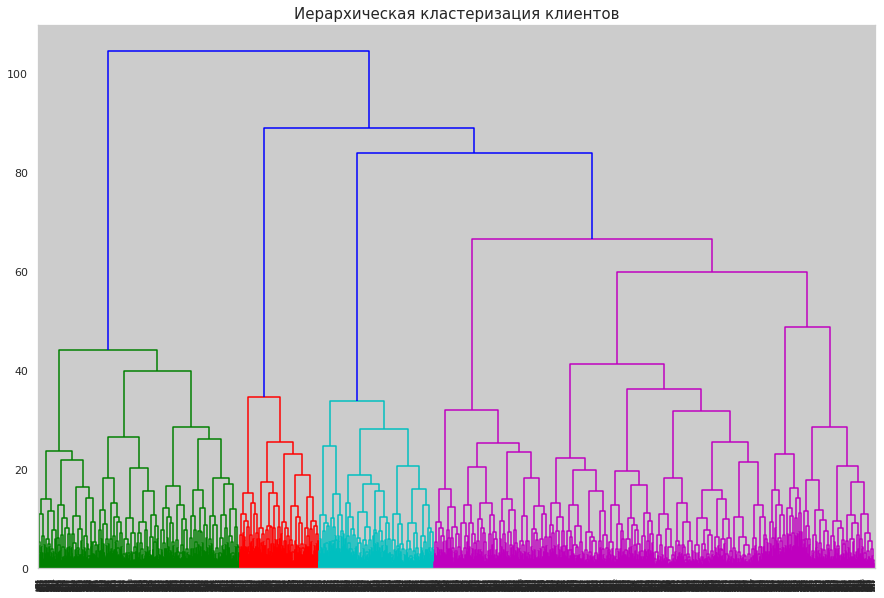

In [26]:
# строим таблицу «связок» между объектами
linked = linkage(X_sc, method = 'ward') 

# визуализируем таблицу "связок" через дендрограмму
plt.figure(figsize=(15, 10))  
plt.title("Иерархическая кластеризация клиентов", size = 15)
dendrogram(linked, orientation = 'top')
plt.show() 

Построение дендрограммы показывает, что пользователей можно разделить на 4 кластера. Чтобы понять, по каким критериям можно произвести деление, обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [27]:
km = KMeans(n_clusters = 5)  # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc)  # формируем метки кластеров
data['cluster'] = labels  # добавляем информацию о кластерах в датасет
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,3
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,4


In [28]:
data.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.523316,0.564868,0.483227,0.500577,0.493590
near_location,0.862694,0.847302,0.723642,0.936563,0.948718
partner,0.471503,0.282434,0.294728,0.740484,0.814103
promo_friends,0.305699,0.071183,0.011182,0.480969,0.998397
phone,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4.777202,2.670494,1.924121,11.833910,3.022436
group_visits,0.427461,0.448909,0.276358,0.547866,0.435897
age,29.297927,30.033295,28.126997,29.891580,29.067308
avg_additional_charges_total,144.208179,161.148821,129.372311,163.330735,141.294953
month_to_end_contract,4.466321,2.470723,1.830671,10.791234,2.831731


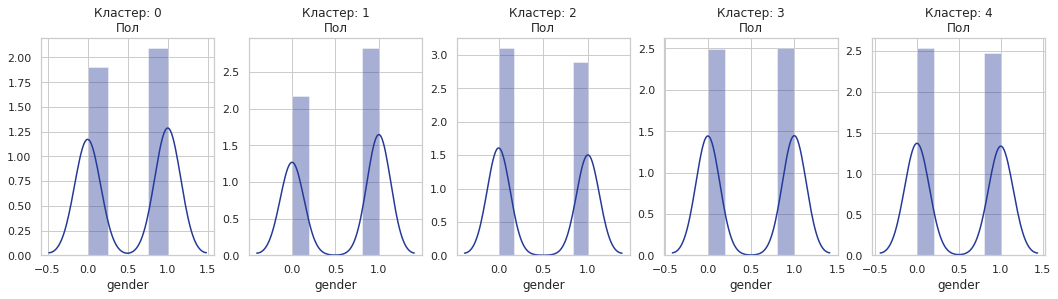

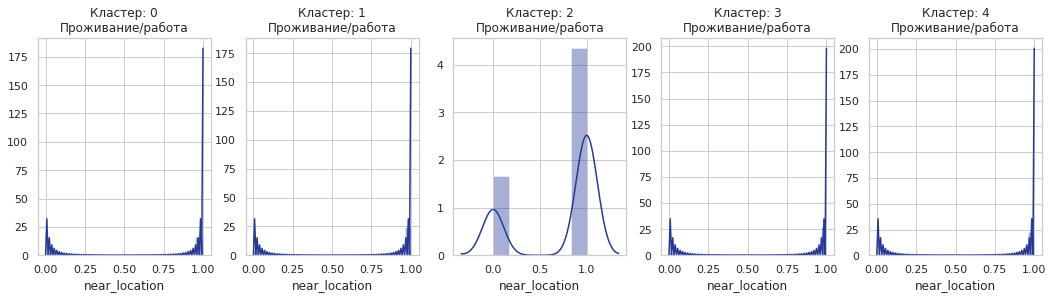

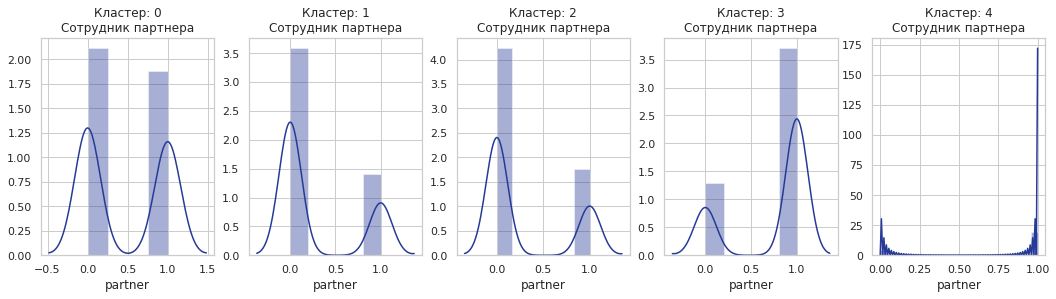

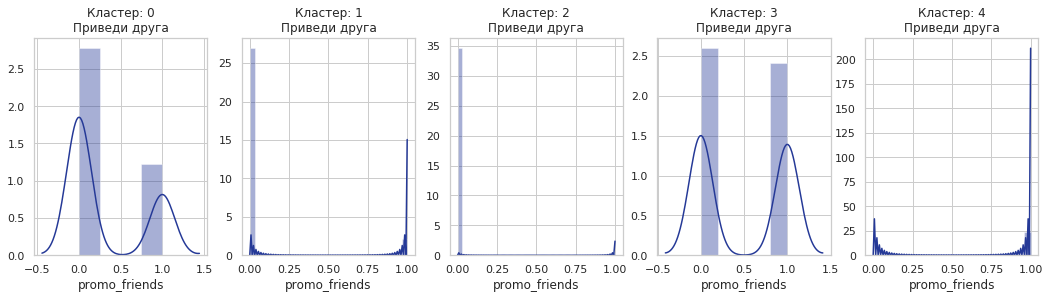

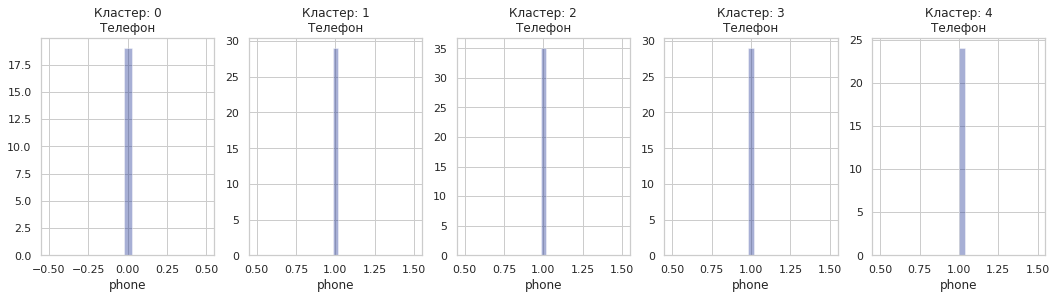

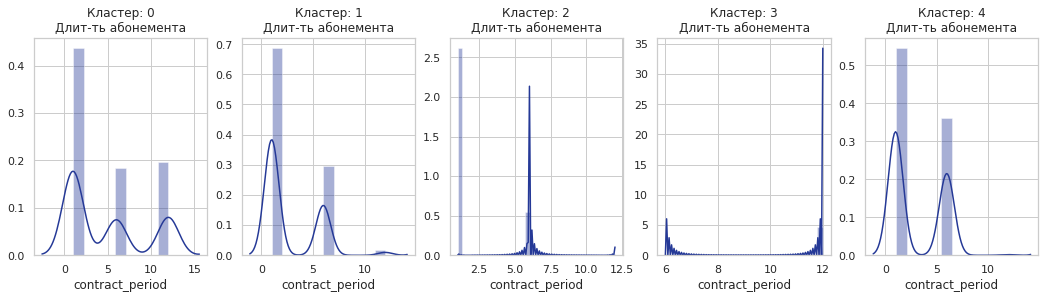

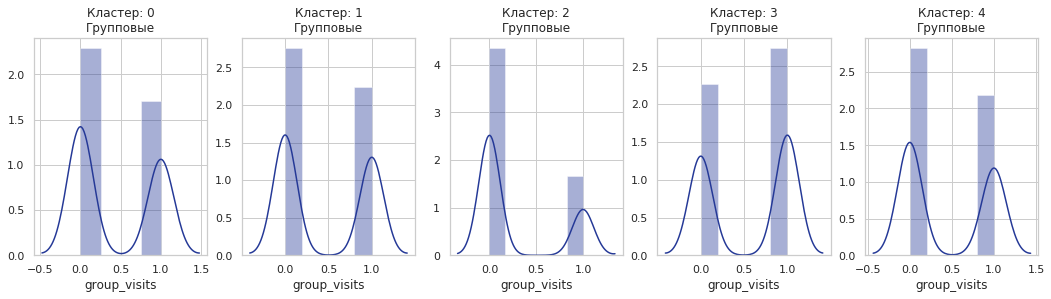

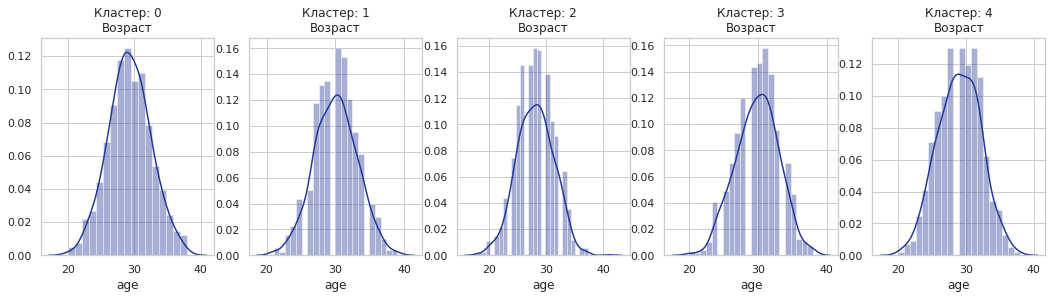

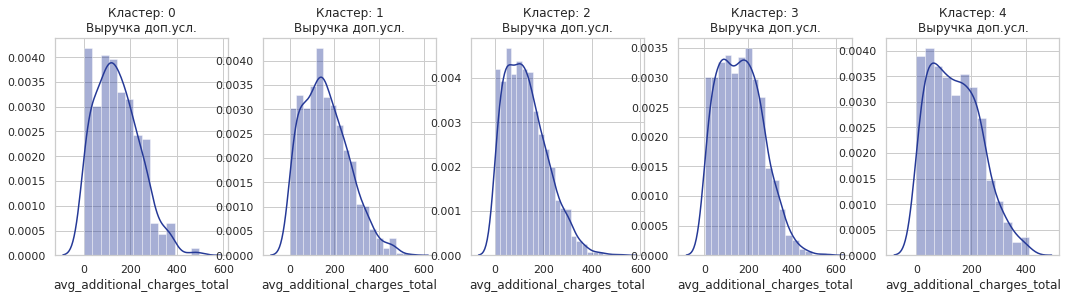

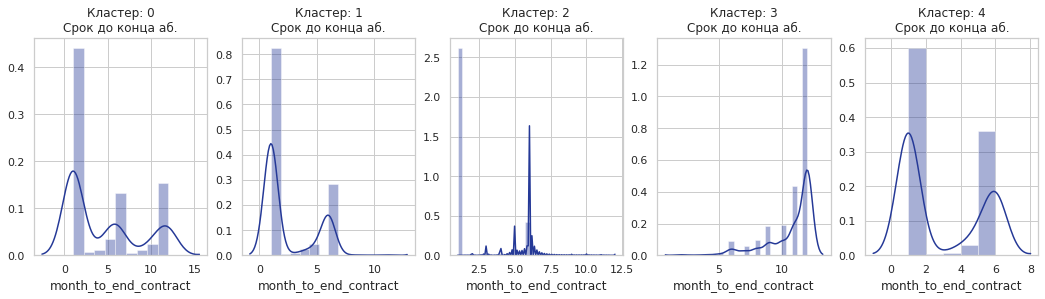

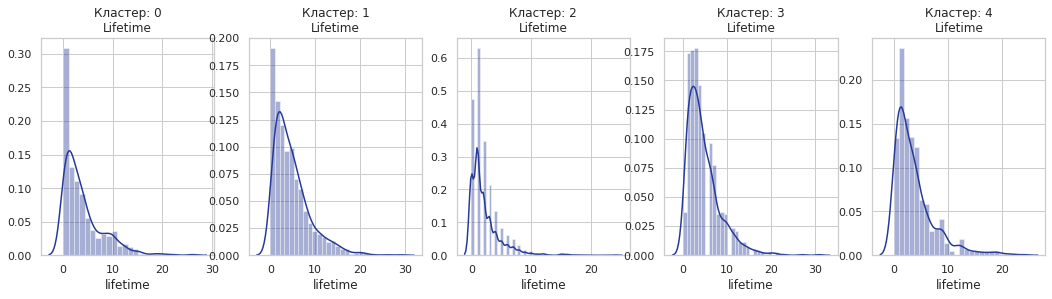

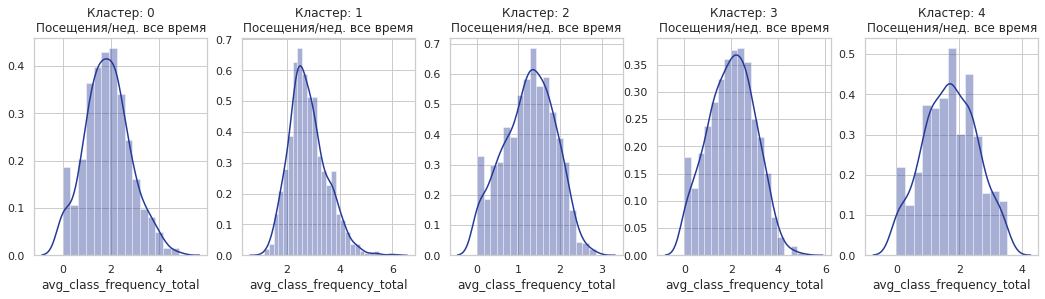

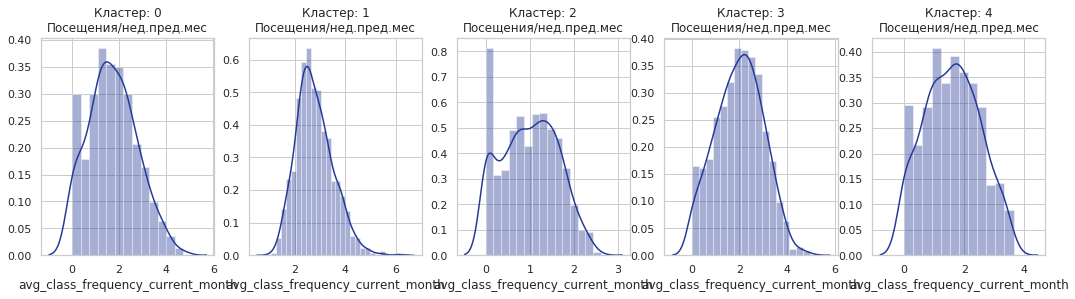

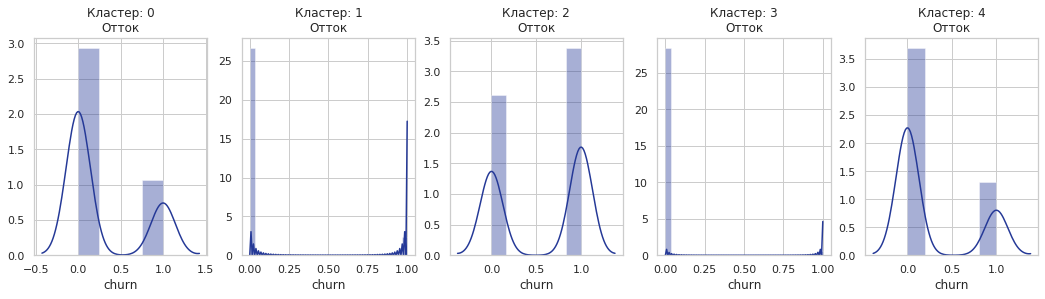

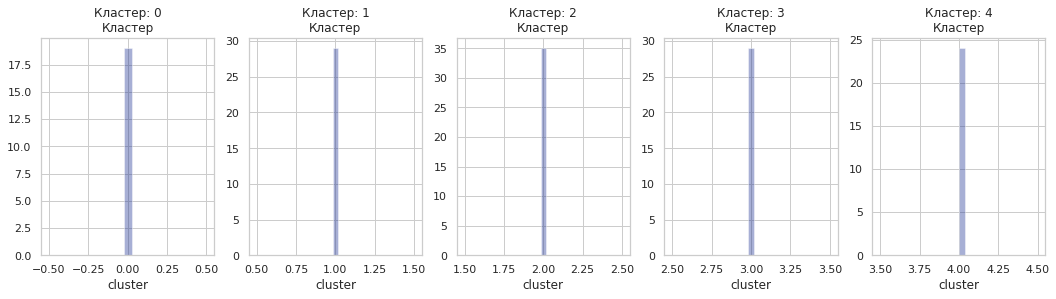

In [29]:
# построим гистрограммы
for feature in data.columns:
    f, axes = plt.subplots(1, len(data['cluster'].unique()), figsize=(18, 4))
    i = 0
    for cluster in np.sort(data['cluster'].unique()):
        data_filtred = data.query('cluster == @cluster')
        sns.distplot(data_filtred[feature], ax = axes[i])
        axes[i].set_title('Кластер: ' + str(cluster) + '\n' + col_names_ru[feature])
        i += 1
    plt.show() 

Для небинарных признаков построим графики "ящик с усами", чтобы сравнить распределения между кластерами.

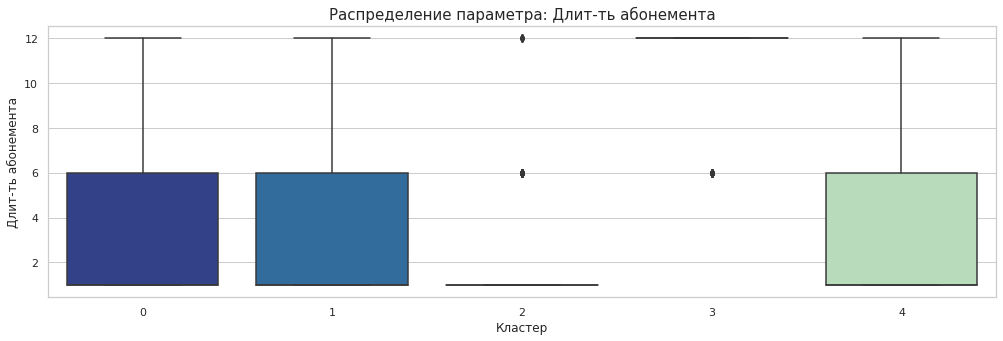

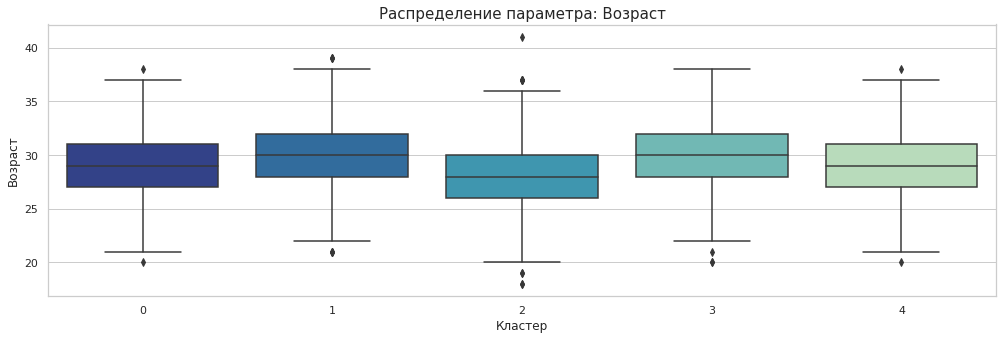

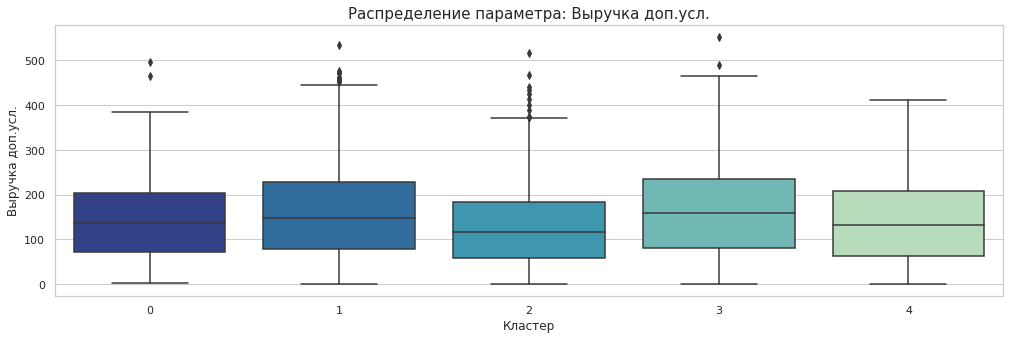

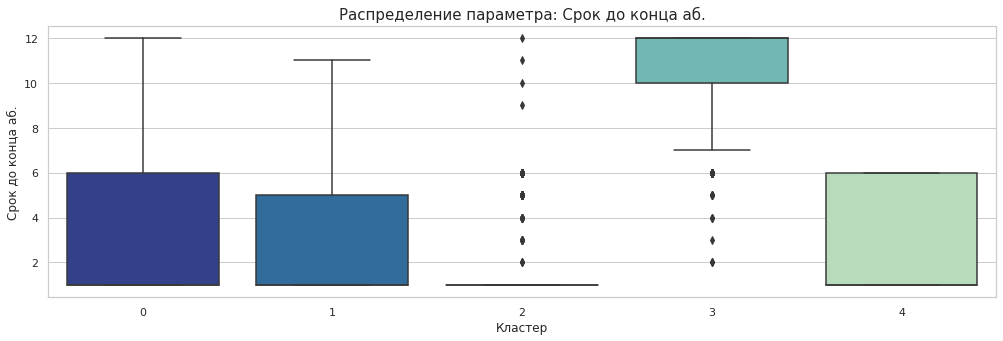

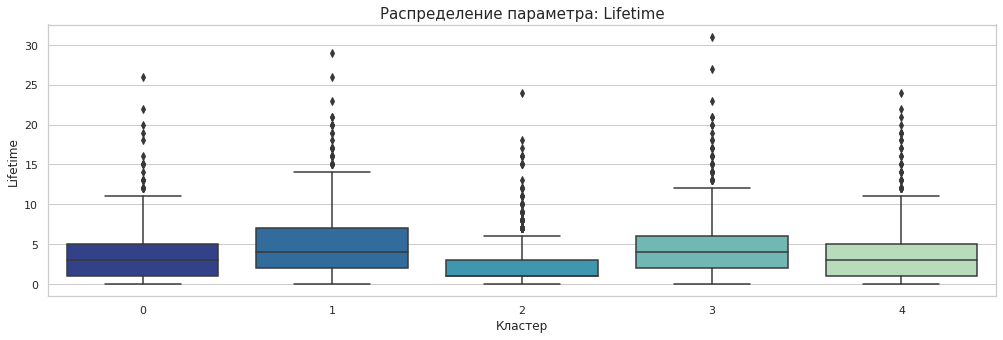

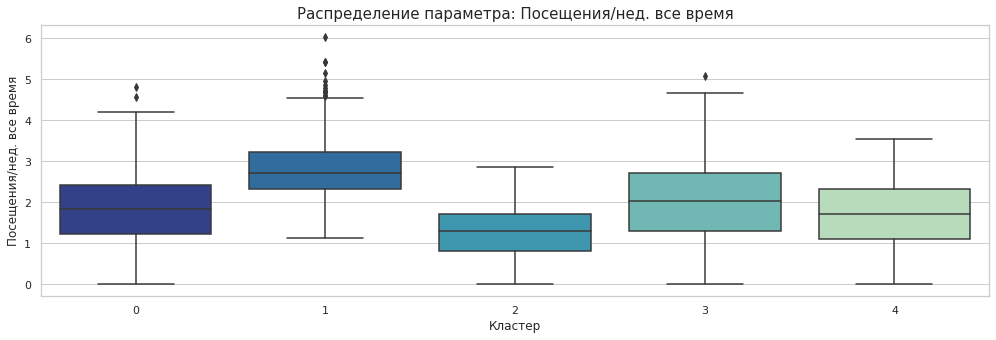

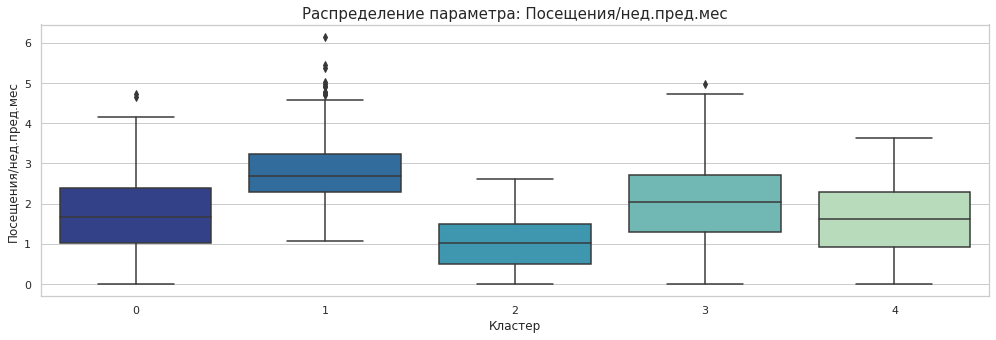

In [30]:
# выделяем небинарные признаки
features = ['contract_period', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

# построим боксплоты
for feature in features:
    plt.figure(figsize = (17,5))
    sns.boxplot(x='cluster', y=feature, data = data)
    plt.title('Распределение параметра: ' + col_names_ru[feature], size = 15)
    plt.xlabel('Кластер')
    plt.ylabel(col_names_ru[feature])
    plt.show()
    print()

In [31]:
# доля оттока (совпадает со средним по параметру churn)
data.groupby('cluster')['churn'].mean().to_frame().style.background_gradient(cmap='Blues')

,churn
cluster,
0,0.266839
1,0.0815155
2,0.563099
3,0.0219146
4,0.261218


In [32]:
# число пользвателей в каждом кластере
data.groupby('cluster')['churn'].count().to_frame().style.background_gradient(cmap='Blues')

,churn
cluster,
0,386
1,871
2,1252
3,867
4,624


Выделился 1 кластер с самым высоким показателем оттока. Высокий показатель оттока у пользователей, которые: 
- имеют небольшой срок контракта,
- реже посещают групповые занятия, 
- самые молодые
- пришли по зову души, а не по рекомендации друга
- меньше всех тратят на доп.услуги

Также выделились еще 2 кластера, отток в которых присутствует, но не такой сильный, как в первом кластере.

Для пользователей, которые ушли в отток: упала частота посещений в прошлом месяце в сравнении с overall частотой посещений. 

# Выводы <a id = 'header_5'></a>

1. **Научились прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.**
Для прогнозирования оттока предлагаем использовать линейную модель, алгоритм линейной регрессии. Эта модель показала себя оптимальной с точки зрения целевой метрики (полнота).


2. **Сформировали типичные портреты клиентов**

    - **Клиенты от партнеров**. Мужчины и женщины в соотношении 50/50, 30 лет, живут близко, пришли от компании-партнера, реже — по приглашению друга. Заключают договор на год. Склонны посещать групповые занятия. Посещают зал 2 раза в неделю. Приобретают доп.услуг больше, чем другие пользователи. Не уходят в отток.
    - **Клиенты от партнеров попроще**. Мужчины и женщины в соотношении 50/50, 29 лет, живут близко, приходят  от компании-партнера или по приглашению друга, заключают контракт на 3-6 месяцев. Могут посещать групповые занятия, но не обязательно. Посещают зал 1-2 раза в неделю. Приобретают доп. услуги умеренно. Пограничная группа с точки риска попадения в отток.
    - **Активные исследователи**. Мужчины и женщины в соотношении 56/44, 30 лет, живут преимущественно рядом, приходят самостоятельно, чаще всего заключают контракт на 3 месяца.  Склонны посещать групповые занятия. Активно посещают зал 2-3 раза в неделю. Активно приобретают доп.услуги. Не уходят в отток.
    - **Средние пользователь: "хочу, но не то, чтобы очень"**. Мужчины и женщины в соотношении 52/48, 29 лет, живут преимущественно рядом, приходят самостоятельно, заключают контракт на 3-6 месяцев, реже на 12. Могут посещать групповые занятия, но не обязательно. Посещают зал 1-2 раза в неделю. Приобретают доп. услуги умеренно. Пограничная группа с точки риска попадения в отток.
    - **Ленивые любопытные котлетки**. Мужчины и женщины в соотношении 57/43, 28 лет, живут не обязательно близко, приходят самостоятельно, могут заключить контракт на месяц. Плохо посещают групповые занятия. Посещают зал 1 раз в неделю. Мало приобретают доп.услуги. Высокий риск оттока.
    

3. **Выявили основные признаки, наиболее сильно влияющие на отток**
    
    Наиболее важными признаками для определния результата оказались: 
    - возраст
    - частота посещений 
    - lifetime — чем дольше человек занимается в фитнесе, тем меньше вероятность, что он перестанет его посещать.
    
    Напрямую влиять можем на частоту посещений, а увеличивая lifetime логично снижаем churn rate.
    Не смотря на то, что именно эти показатели дают самый весомый вклад, стоит обратить внимание и на те показатели, на которые нам проще  влиять и которые так же вносят значимый вклад: 
    
    - длительность контракта
    - посещение групповых занятий
    - доп.траты
    
    
4. **Выводы и рекомендации по повышению качества работы с клиентами**:
    - *Целевые группы клиентов*. В первую очередь стоит сосредоточиьтся на клиентах, которые находятся в пограничной группе риска попасть в отток. Для того, чтобы удержать этих пользователей, неужно меньше затрат, чем для удержания тех, кто с большой вероятностью отвалится. К тому же, в сумме людей в пограничных кластерах не сильно меньше, чем в самом критичном.  
    - *Меры по снижению оттока*. Заключение договора сразу на год (программа рассрочки); вводная программа вовлечения в групповые занятия; помощь в составлении расписания на первой неделе для увеличения частоты посещения; проведения акций для увеличения доп.затрат на услуги и закрепления позитивного впечатления от посещения, выработку привычки (пить самый вкусный смузи в городе после тренировки и возвращаться за ним снова и снова).
